# Using Spark to do Anamoly predictions for streaming data
We well use spark and a simple anomoly detector to look at the data from 30 different instrument streams coming through Kinesis.   We use Spark instead of Spark Streaming for two reasons.  First the Kinesis connector for Spark is somewhat unreliable and we want to do the anaomoly detection explicitly in the notebook.  

The data set being used here is based on a 24 hour sample of event streams of about 40 instruments similar to the ones used in the Chicago Array of Things project.  This data set is available for download.  A seperate program is used to read the dataset and push the events as fast as possible to Kinesis.   With one shard we can push the full collection of events to Kinesis in 40 minutes.  

## setup
To use this notebook you need an AWS account and a Kinesis stream.   There are several invironments in which this will run 
<ul>
<li> the jupyter/all-spark-notebook.   
<li> The Azure linux DataScienceVM.
</ul>
## jupyter/all-spark-notebook
you can run it with the following command

docker run -it --rm -p 8888:8888  -v path-to-your-notebooks:/notebooks jupyter/all-spark-notebook

The path to your notebooks is where you keep a copy of this notebook.

You will also need you AWS crentials.   If you are running on your own machine can avoid loading your credentials explicitly of you can add a 

-v path-to-your-.aws:.aws

to the above docker command.
You will also need to install boto3 and tzlocal.  see below.
Finally you will need the spark context object sc -  again see below.
## Azure linux DataScienceVM
For this you are likely going to come in through JupyterHub at http://yourmIP:8000
You will need to have the manager of the VM do the boto3 install and then you will need to do it locally.  have that person execute the following 

sudo /anaconda/envs/py35/bin/pip install boto3

sudo /anaconda/bin/pip install boto3

and do the same with tzlocal. Then you need to do it one more time as shown below.
you will still need to  upload this notebook and you will need to have your aws credentials.

When you load the notebook into Jupyter make sure you run with the kernel Spark-python. you can set it from the Kernel dropdown menu.

## The data to send to Kinesis
The data and a program to send the data to Kinesis is in the directory kinesis-spark-AoT in the same place where you found this.  You need to run

In [1]:
#This is where you need to install boto3 and tzlocal
#if you are running in the azure datascienceVM uncomment these two lines
#!/anaconda/bin/pip install boto3
#!/anaconda/bin/pip install tzlocal

#if you are running Jupyter/all-spark-notebook then uncomment these two lines
#!pip install boto3
#!pip install tzlocal


In [8]:
import boto3
import time
import datetime
from tzlocal import get_localzone
import pytz
import json
from dateutil.parser import parse
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from pylab import rcParams
%matplotlib inline

## make sure we have the Spark Context

In [2]:
#If you are running in the Azure linux datascienceVM with the Spark-python kernel 
#you do not have do do anything.  you should already have the spark context as sc as shown below
#if you are running in the Jupyter/all-spark-notebook you need to run these
#two lines
#from pyspark import SparkContext
#sc= SparkContext('local', 'pyspark')

In [9]:
sc

### Establish  Kinesis connection
The following code will create a list of interators: one for each shard of the Kinesis stream.  Normally we would run a seperate thread for each shard, but this allows us to treat all shards directly in the notebook.

In [10]:
client = boto3.client('kinesis')
#you may need to do the full boto3 client initialization.  if so it is
#client = boto3.client('kinesis', region_name = 'us-west-2',
#                     aws_access_key_id = 'ACCESSKEY',
#                     aws_secret_access_key = 'secretkey'
#)

In [11]:
resp = client.describe_stream(StreamName='cloudbook2')

In [12]:
resp['StreamDescription']['Shards']

[{u'HashKeyRange': {u'EndingHashKey': u'340282366920938463463374607431768211455',
   u'StartingHashKey': u'0'},
  u'SequenceNumberRange': {u'StartingSequenceNumber': u'49568010070907680776027624049779492907423446025881255938'},
  u'ShardId': u'shardId-000000000000'}]

In [13]:
shardlist = []
startkeys = []
for shard in resp['StreamDescription']['Shards']:
    shardlist.append({'ShardId':shard['ShardId'], 'seqno':shard['SequenceNumberRange']['StartingSequenceNumber']})
    

In this case the stream cloudbook2 has only one shard.  

In [14]:
shardlist

[{'ShardId': u'shardId-000000000000',
  'seqno': u'49568010070907680776027624049779492907423446025881255938'}]

iterlist below will be our list of iterators.

In [15]:
iterlist = []
for shard in shardlist:
    iter = client.get_shard_iterator(
        StreamName='cloudbook2',
        ShardId=shard['ShardId'],
        ShardIteratorType = 'LATEST',
        )
    iterlist.append({'iterator': iter['ShardIterator']})  

## Spark and Kinesis stream related funtions
Our spark-Kinesis pipeline will have four stages.  The first phase creates the RDD in our psudo D-Stream.  

1. gather_list(iteratorlist) takes the list of Kinesis stream iterators and pulls all the events since the last call to this function from the stream.  it then updates the iteratorlist with the iterator set to the spot that follows the last one we pulled.  Each event is a binary-encoded json object so it is converted into a full json object and then to a list.  This is done by the function extractData and dictolist() which returns a list of all the events that were just pulled.

2. filter_fun(row, sensor, parameter) is used to select the elements of the RDD that correspond to a specific sensor, parameter pair.

In [19]:
def dictolist(row):
    nl = []
    for key, value in row.iteritems():
        nl.append([key,value])
    return nl

def extractData(res):
    #res is the response['Records'] field
    lis = []
    for rec in res:
        data = rec['Data']
        arivetime = rec['ApproximateArrivalTimestamp']
        item = json.loads(data)
        nitem = dictolist(item)
        lis.append(nitem[0])
    return lis

def filter_fun(row, sensor, parameter):
    key = sensor+'_'+parameter
    print row
    if row[0] == key:
        return True
    else:
        return False

def gather_list(iterlist):
    listforRDD = []
    for iter in iterlist:
        resp = client.get_records(ShardIterator=iter['iterator'])
        listforRDD.append(extractData(resp['Records']))
        iter['iterator'] = resp['NextShardIterator']
    if listforRDD == []:
        return []
    else: 
        return listforRDD[0]

#doiter convers a list of the form [x, iterator] to [x, [list of items]]
def doiter(row):
    l = []
    if row == []:
        return []
    else:
        for it in row[1]:
            l.append(it)
        return [row[0], l]


    

## Datarecorder is a class for creating objects that are used to keep a record a stream

It has one main method: record_newlist( newlist) which takes a list of event records of the form 
(timestamp, value) and appends it to self.datalist which is the record of the stream.  In addition to this record we will use the recent history of the stream to signal unexpected changes in the stream such as anomolies or other major changes in behavior.   However, some instrument streams can be very noisy and we must look for ways to filter the noise to see the significant changes in behavior.

To filter the noise in a stream $x_i$ we can use an exponential based smoothing technique which blends the previous values from the stream to create an artificial stream $s_i$ that tends to a geometric average of past values as follows.   Let $s_0 = x_0$ and use the recurrence 
$$s_n = (1-\alpha)x_n + \alpha s_{n-1} $$
where $\alpha$ is a number between 0 and 1,to define the future values.  Expanding the recurrence we see that
$$s_n = (1-\alpha)X_n + \alpha (1-\alpha)x_{n-1} + \alpha^2 s_{n-2} $$
$$s_n = (1-\alpha)\sum_{i=0}^{n-1}\alpha^ix_{n-i}+ \alpha^nx_0 $$

(It is easy to verify that in the case of a constant stream: $x_i=x_0$ for all $i$, then $s_i$ = $x_i$  for all $i$.) However if the stream make a radical change in value then the smooted value will lag behind.   We can use this to signal anomolies and other points of behavior change.   But the problem then becomes how to measure a profound change in behavior in a maner that is distinct from noise.   To do that we can compute the standard deviation and look for departures from our smoothed value that exceed the standard deviation.   

We can't truely compute the standard deviation of values in a stream that may dramatically change over time, but we can compute the stadard deviation in a recent window.   Let $buff_i$ for $i=1,M$ be a  record of the "last" $M$ stream values.   we can compute the standard deviation $\sigma$ in this window with
$$\mu = \frac{1}{M}\sum_{i=1}^M buff_i$$
$$\sigma = \sqrt{\frac{1}{M}\sum_{i=1}^M (buff_i - \mu)^2}$$
Based on this computation we can look for values of $x_i$ that lay outside the interval $[s_i-k\sigma, s_i+k\sigma]$ where $k$ is some value greater than 1.   We use $k=1.3$ here.  While $2\sigma$ would show us some truely significant outliers, we found the more modest $1.3\sigma$ worked well.

For fun, we also keep a record of $s_i$, $s_i-k\sigma$ and $s_i+k\sigma$ that we can plot after we complete the analysis.

In [115]:
class Datarecorder:
    def __init__(self, listname):
        self.M = 20
        self.databuff = np.empty(self.M)
        self.itemcnt = 0
        self.predicted = []
        self.high = []
        self.low = []
        self.datalist = []
        self.old_smoothed = 0.0
        self.smoothed = 0.0
        self.alpha = 0.04
        self.name = listname
        self.sigmaold = 0.0
    def record_newlist(self, newlist):
        #print newlist
        topiclis = self.datalist
        if topiclis == None:
            topiclis = []
        for x in newlist:
            if self.itemcnt < 5:
                alpha1 = 0.9
                if self.itemcnt == 0:
                    self.old_smoothed = float(x[1])
                    self.databuff[:] = float(x[1])
            else:
                alpha1 = self.alpha
            #print x
            self.smoothed = alpha1*float(x[1])+ (1-alpha1)*self.old_smoothed
            pr = self.old_smoothed
            self.predicted.append([x[0], pr])
            self.old_smoothed = self.smoothed
            topiclis.append(x)
            
            #now we will compute a smoothed standard deviation 
            std_window = 1.3
            gama = 0.01
            sigmasq = 0.0
            mu = 0.0
            for j in range(self.M):
                mu += self.databuff[j]
            mu = mu/self.M
            for j in range(self.M):
                sigmasq += (self.databuff[j]-mu)**2
            self.databuff[self.itemcnt%self.M] = x[1]
            sigma = np.sqrt(sigmasq)
            sigma = gama*sigma + (1-gama)*self.sigmaold
            self.sigmaold = sigma
            low = pr - std_window*sigma
            high= pr + std_window*sigma
            self.low.append([x[0], low])
            self.high.append([x[0], high])
            #print('sigma = %f  low = %f high = %f'%(sigma, low, high))
            if (self.itemcnt > 50*self.M) and ((x[1]> high) or (x[1]< low)):
                print("anomoly at time %s"%x[0])
            self.itemcnt += 1
        self.datalist = topiclis
# plot the record of the stream as well as the predicted(smoothed) stream and the high and low bounds.
    def plotdata(self):
        data = {'date': [x[0] for x in self.datalist],
                'value': [x[1]for x in self.datalist]}
        #print data
        df = pd.DataFrame(data, columns = ['date', 'value'])
        #print df
        tvas = pd.to_datetime(df['date'])
        v = pd.to_numeric(df['value'])

        data = {'date': [x[0] for x in self.predicted],
                'value': [x[1] for x in self.predicted]}
        dfpred = pd.DataFrame(data, columns = ['date', 'value'])
        tvaspred = pd.to_datetime(dfpred['date'])
        vpred = pd.to_numeric(dfpred['value'])

        data = {'date': [x[0] for x in self.low],
                'value': [x[1] for x in self.low]}
        dflow = pd.DataFrame(data, columns = ['date', 'value'])
        tvaslow = pd.to_datetime(dflow['date'])
        vlow = pd.to_numeric(dflow['value'])

        data = {'date': [x[0] for x in self.high],
                'value': [x[1] for x in self.high]}
        dfhigh = pd.DataFrame(data, columns = ['date', 'value'])
        tvashigh = pd.to_datetime(dfhigh['date'])
        vhigh = pd.to_numeric(dfhigh['value'])

        rcParams['figure.figsize'] = 20, 5
        with plot.style.context('fivethirtyeight'):
            plot.plot(tvas, v, linewidth = 2)
            plot.plot(tvaspred, vpred, linewidth = 2)
            plot.plot(tvaslow, vlow, linewidth = 2)
            plot.plot(tvashigh, vhigh, linewidth = 2)
       


## we will look at two out of 40 streams
by creating a dictionary of the data recoders for each stream of interest.   The ones we have chosen show some interesting behavior that we can track.   One is a chemistry sensor that tracks atmospheric $no_2$ a common polutant and the other sensor is just an ambient temperature sensor.  

The function update_records(newlist) takes a list of the form
<pre>
[ [sensor-name, [[time-stamp, value], [time-stamp, value] .... ]
  [sensor-name, [[time-stamp, value], [time-stamp, value] .... ]
  ..
 ]
</pre>
and uses the dictionary to select the correct recorder and pass the timestamp, value list to the recorder function.

In [116]:
myrecorder = {}
myrecorder['Chemsense_no2'] = Datarecorder('Chemsense_no2')
myrecorder['TSYS01_temperature'] = Datarecorder('TSYS01_temperature')

def update_recorders(newlist):
    if newlist != None and newlist != []:
        #print newlist
        for x in newlist:
            print("updating list for %s"%x[0])            
            myrecorder[x[0]].record_newlist(x[1])


# the main loop
Using a seperate process we push the 40 synthetic sensor streams to the Kinesis shard.   The loop below emulates a sparkstreaming use case.  Approximately every 20 seconds we gather all available events from the kinesis stream and then create a spark RDD for them called $data$.   Each event is a list of the form
<pre>
[sensor-name, [timestamp, value]]
</pre>
The first step in the pipeline filters all events except those we are interested in keeping.  

The second step groups the events by the sensor-name key in the tuple.  this results in a list with two elements
<pre>
[['Chemsense-no2', [python-interator over the (time-stamp, value) tuples]],
 ['TSY01-temperature', [python-iterator over the (time-stamp, value) tuples]
]
</pre>
The third step uses map to conver the python interators into explicit lists.

Finally we collect this into a list $newlist$ which we pass to the recorders to record and look for events of interest.

Note that the data in the data set covers 24 hours of real data where the instruments sent an event approxilately every 25 seconds. This is approximately 2 events per minute for a total of approximately 3450 for the full day. All together there are 172,800 events in the dataset and the total size is approximaately 14MB.   We are pushing this all to Kinesis in about $120*20 seconds = 40$ minutes using one shard.  We could do it much faster with 2 shards.

In [24]:

for i in range(150):
    gathered = gather_list(iterlist)
    data = sc.parallelize(gathered, 2)
    newlist = data.filter(lambda p: filter_fun(p, 'Chemsense', 'no2') 
                                 or filter_fun(p,'TSYS01','temperature')) \
                  .groupByKey()                                            \
                  .map(lambda p: doiter(p))                                \
                  .collect()
    update_recorders(newlist)
    print('**********  end of gather %s ***************'%i)
    time.sleep(20.0)


##  the following is edited output from the above.  The first 80 event gatherings have been deleted because nothing happened.

you will notice that the first anomolies occur for the Chemsense_no2 detector at 17:05 and persist until 17:13.  For the temperature sensor the anomolies start at 17:15 and continue to go to 17:39.   The temperature sensor continues to see strange spikes around 23:03 and continue for another 14 minutes.  

<pre>
**********  end of gather 80 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 81 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 82 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 83 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 84 ***************
updating list for Chemsense_no2
anomoly at time 2016-11-10 17:05:06.980000
anomoly at time 2016-11-10 17:05:57.049000
anomoly at time 2016-11-10 17:06:22.081000
anomoly at time 2016-11-10 17:06:47.132000
anomoly at time 2016-11-10 17:07:12.172000
anomoly at time 2016-11-10 17:07:37.212000
anomoly at time 2016-11-10 17:08:02.264000
anomoly at time 2016-11-10 17:08:27.321000
anomoly at time 2016-11-10 17:08:52.383000
anomoly at time 2016-11-10 17:09:17.417000
anomoly at time 2016-11-10 17:09:42.453000
anomoly at time 2016-11-10 17:10:07.489000
anomoly at time 2016-11-10 17:10:57.572000
anomoly at time 2016-11-10 17:11:22.623000
anomoly at time 2016-11-10 17:11:47.692000
anomoly at time 2016-11-10 17:13:01.802000
anomoly at time 2016-11-10 17:13:26.838000
anomoly at time 2016-11-10 17:13:51.875000
updating list for TSYS01_temperature
anomoly at time 2016-11-10 17:15:57.064000
anomoly at time 2016-11-10 17:16:22.100000
anomoly at time 2016-11-10 17:17:37.232000
**********  end of gather 85 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
anomoly at time 2016-11-10 17:18:02.271000
anomoly at time 2016-11-10 17:19:42.442000
anomoly at time 2016-11-10 17:20:07.482000
anomoly at time 2016-11-10 17:20:32.550000
anomoly at time 2016-11-10 17:20:57.582000
anomoly at time 2016-11-10 17:21:22.617000
anomoly at time 2016-11-10 17:21:47.653000
anomoly at time 2016-11-10 17:22:11.685000
anomoly at time 2016-11-10 17:22:36.727000
anomoly at time 2016-11-10 17:23:01.785000
anomoly at time 2016-11-10 17:23:26.843000
anomoly at time 2016-11-10 17:23:51.874000
anomoly at time 2016-11-10 17:24:16.907000
anomoly at time 2016-11-10 17:24:41.951000
anomoly at time 2016-11-10 17:25:06.995000
anomoly at time 2016-11-10 17:25:32.034000
anomoly at time 2016-11-10 17:25:57.090000
anomoly at time 2016-11-10 17:26:22.130000
anomoly at time 2016-11-10 17:26:47.162000
anomoly at time 2016-11-10 17:27:12.199000
anomoly at time 2016-11-10 17:27:37.236000
anomoly at time 2016-11-10 17:28:02.279000
anomoly at time 2016-11-10 17:28:27.322000
anomoly at time 2016-11-10 17:28:52.363000
anomoly at time 2016-11-10 17:29:17.405000
anomoly at time 2016-11-10 17:29:42.460000
anomoly at time 2016-11-10 17:30:07.507000
**********  end of gather 86 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
anomoly at time 2016-11-10 17:30:32.595000
anomoly at time 2016-11-10 17:30:57.637000
anomoly at time 2016-11-10 17:31:22.675000
anomoly at time 2016-11-10 17:31:47.740000
anomoly at time 2016-11-10 17:32:11.786000
anomoly at time 2016-11-10 17:32:36.824000
anomoly at time 2016-11-10 17:33:01.864000
anomoly at time 2016-11-10 17:33:26.909000
anomoly at time 2016-11-10 17:33:51.942000
anomoly at time 2016-11-10 17:34:16.984000
anomoly at time 2016-11-10 17:35:57.144000
anomoly at time 2016-11-10 17:36:22.179000
anomoly at time 2016-11-10 17:36:47.244000
anomoly at time 2016-11-10 17:37:12.305000
anomoly at time 2016-11-10 17:37:37.412000
anomoly at time 2016-11-10 17:38:02.456000
anomoly at time 2016-11-10 17:39:17.570000
**********  end of gather 87 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 88 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 89 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 90 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 91 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 92 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 93 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 94 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 95 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 96 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 97 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 98 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 99 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 100 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 101 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 102 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 103 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 104 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 105 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 106 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 107 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 108 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
anomoly at time 2016-11-10 22:16:26.707000
anomoly at time 2016-11-10 22:16:51.752000
anomoly at time 2016-11-10 22:17:16.804000
anomoly at time 2016-11-10 22:17:41.851000
anomoly at time 2016-11-10 22:18:06.893000
anomoly at time 2016-11-10 22:18:31.940000
anomoly at time 2016-11-10 22:19:22.065000
anomoly at time 2016-11-10 22:20:37.233000
anomoly at time 2016-11-10 22:21:02.302000
**********  end of gather 109 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
anomoly at time 2016-11-10 22:23:07.533000
anomoly at time 2016-11-10 22:23:32.592000
anomoly at time 2016-11-10 22:24:22.673000
anomoly at time 2016-11-10 22:25:37.789000
anomoly at time 2016-11-10 22:26:51.921000
anomoly at time 2016-11-10 22:27:17.973000
anomoly at time 2016-11-10 22:27:42.023000
anomoly at time 2016-11-10 22:28:07.069000
anomoly at time 2016-11-10 22:28:32.142000
anomoly at time 2016-11-10 22:28:57.174000
**********  end of gather 110 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 111 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 112 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
anomoly at time 2016-11-10 23:03:07.733000
anomoly at time 2016-11-10 23:03:32.768000
anomoly at time 2016-11-10 23:03:57.803000
anomoly at time 2016-11-10 23:04:22.871000
anomoly at time 2016-11-10 23:04:47.934000
anomoly at time 2016-11-10 23:05:13.968000
anomoly at time 2016-11-10 23:05:38.012000
anomoly at time 2016-11-10 23:06:03.049000
anomoly at time 2016-11-10 23:08:58.305000
anomoly at time 2016-11-10 23:09:23.343000
**********  end of gather 113 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
anomoly at time 2016-11-10 23:09:48.378000
anomoly at time 2016-11-10 23:12:43.730000
anomoly at time 2016-11-10 23:14:47.974000
anomoly at time 2016-11-10 23:17:18.233000
**********  end of gather 114 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 115 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 116 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 117 ***************
updating list for Chemsense_no2
updating list for TSYS01_temperature
**********  end of gather 118 ***************
**********  end of gather 119 ***************
</pre>

## Each recorder keeps track of the data, 
and the smoothed prediction and the $3\sigma$-wide saftey widow.  The plot function will show the history.  One can clearly see the periods of strange behavior.

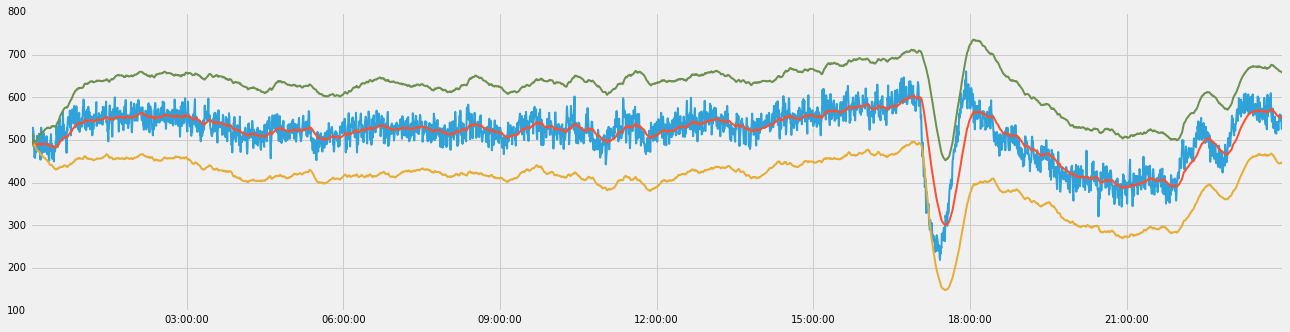

In [118]:
myrecorder['Chemsense_no2'].plotdata()

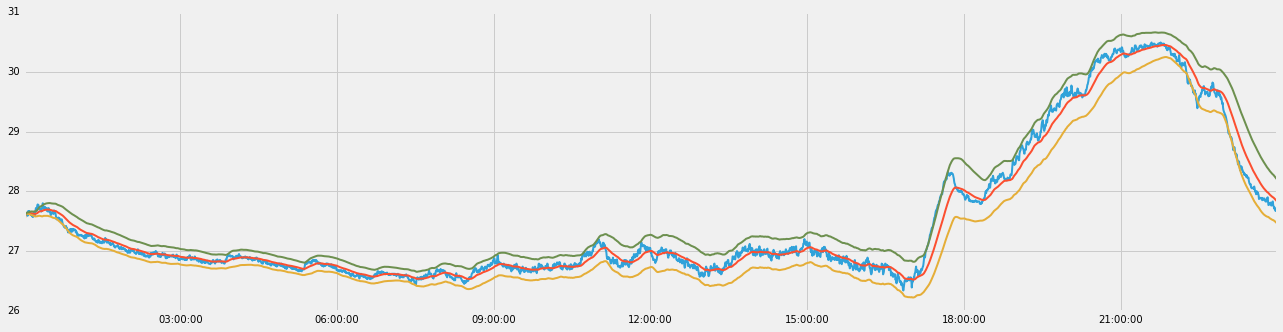

In [119]:
myrecorder['TSYS01_temperature'].plotdata()